In [1]:
%matplotlib notebook
from test_utils import *
from cg import Point, turn # Точка и предикат повотора

# Локализация в PSLG методом полос

   Перед нами стоит одна из классических задач вычислительной геометрии: необходимо по заданному плоскому графу $G$ и точке запроса $q$ определить какому фейсу $F$ из $G$ она принадлежит.

Заметим, что если определить какое ребро выше, а какое ниже точки запроса, то можно однозначно определить какому фейсу принадлежит точка.
Для решения воспользуемся следующей идей: сначала локализуемся по координате $X$, а затем по координате $Y$.
Для этого через каждую вершину PSLG проведем вертикальную прямую. В итоге мы разбили всю плоскость на полосы.

![Пример разбиения плоскости](slideshow/images/SLABS.png)
<center><font size=2>Рис. 1. Пример разбиения плоскости на полосы </font></center>

   Теперь отсортируем полосы по координате $X$. 
Это позволит нам с помощью двоичного поиска за $O(\log{n})$ найти полосу, в которую попала точка запроса.
Заметим, что по построению ребра могут пересекаться только на границах полос.
Следовательно, внутри одной полосы ребра вертикально упорядочены.
Значит, мы можем хранить для каждой полосы, например, дерево поиска и за $O(\log{n})$ локализоваться в ней.
   
### Упражнение 1
   Вам необходимо упорядочить ребра в полосе.
Для этого вам необходимо реализовать функцию `less`.
Она принимает два аргумента:

* `a` – первое ребро,
* `b` – второе ребро, где каждое ребро – это список из двух `Point`.

Функция `less` должна возвращать `True`, когда ребро `a` меньше ребра `b`, и `False` в противном случае.

Вы можете пользоваться функцией `turn(a, b, c)` из `cg`, которая определяет поворот точки $c$ относительно отрезка $ab$.

Гарантируется, что отрезки не пересекаются.
Заметим, что хотя отрезки находятся в одной полосе, координаты $X$ четырех точек, которые их образовывают, могут не совпадать.

In [3]:
def less(a, b):
    """
    Здесь должно быть ваше решение
    """
    
    return correct_comparator(a, b)

test_comparator(less)

Running test # 1
Passed
Running test # 2
Passed
Running test # 3
Passed
Running test # 4
Passed
Running test # 5
Passed
Running test # 6
Passed
Passed all tests


### Упражнение 2
Вам необходимо реализовать алгоритм локализации в полосе.

Для этого вам необходимо реализовать функцию `locate`.
Она принимает два аргумента:

* `point` – точка запроса,
* `edges` – список ребер.

Как и в предыдущем упражнении Вы можете пользоваться функцией `turn(a, b, c)` из `cg`.

Функция должна возвращать кортеж `(i, j)`, где `i` – индекс ребра снизу, а `j` – сверху.
Если ребра снизу нет, то `i` должен быть равен $-1$.
Если отсутствует верхнее ребро, то `j` должен быть равен `len(edges)`.

Это интерактивная модель, поэтому Вы можете проверить корректность решения, просто сделав несколько кликов внутри полосы.

<IPython.core.display.Javascript object>


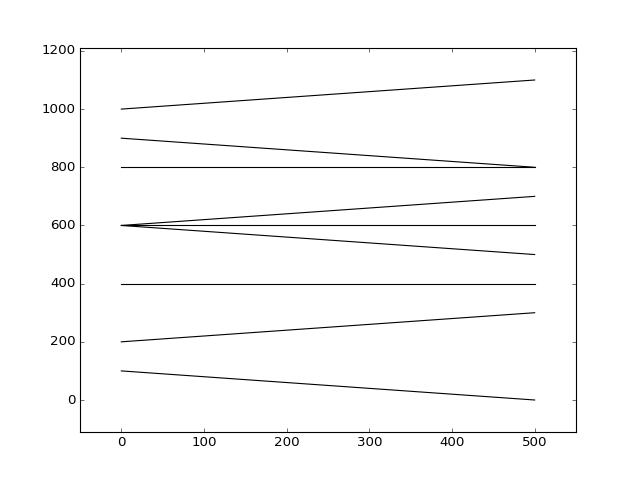

In [15]:
slab = Slab.read_slab("sample01.txt")


def locate(edges, point):
    # Сейчас тут стоит заглушка, чтобы не отрисовывать красным никакие ребра
    # Напоминание: в python целочисленное деление выполняется оператором //
    return None


def on_click(event):
    fig.clear()
    point = Point(int(round(event.xdata)), int(round(event.ydata)))
    loc = locate(slab.edges, point)
    slab.draw(loc, point)
    
fig = plt.figure(num='  ')
fig.canvas.mpl_connect('button_press_event', on_click)
slab.draw()


Сразу отметим, что в предыдущем упражнении мы хранили ребра в списке только для простоты постановки задачи.
Так как ребра в полосе упорядочены, то при реализации алгоритма саму полосу удобно хранить в виде сбалансированного дерева поиска.

Сейчас вы уже умеете искать нужную полосу и локализоваться в ней.
Теперь немного поговорим о том, как построить сами полосы.

Рассмотрим две соседние полосы.
Заметим, что полоса справа отличается от полосы слева тем, что в ней появились и исчезли какие-то отрезки.
Значит, следующую полосу можно получить, если добавить в неё новые отрезки и удалить исчезнувшие.
Следовательно, для одного отрезка (ребра) у нас есть события двух типов:

* `insert`, когда мы его вставляем,
* `delete`, когда мы его удаляем.

Событию вставки будет соответствовать начало отрезка, а конец удалению.
Так как событие происходит в какой-то точке, то сравнивать события мы будем, как точки.
Сами точки сравниваются лексикографически.
Следовательно, алгоритм становится следующим: отсортируем все события, затем будем по очереди доставать события и выполнять их.
При этом понятно, что если $X$ координата события не совпадает с $X$ координатой текущей полосы, то это событие уже относится к новой полосе.

Заметим, что вместо того, чтобы сортировать события можно завести приоритетную очередь и положить их все туда, а потом их оттуда доставать.

В следующей ячейке следует возможная реализация алгоритма построения локализационной структуры.

In [2]:
import utils

def createSearchingDataStructure(edges: list):
    currentSlab = SortedSet()
    events = list()
    slabs = list()

    # Добавляем в список все события
    for e in edges:
        events.append(Event(e.origin, e, Event.EventType.INSERT))
        events.append(Event(e.destination, e, Event.EventType.DELETE))

    # Делаем список событий кучей
    heapq.heapify(events)
    
    # Пока есть события, крутимся в следующем цикле
    while len(events) != 0:
        # Достаем из приоритетной очереди следующее событие
        event = heapq.heappop(events)

        if len(slabs) == 0 or (event.x, currentSlab) != slabs[-1]:
            # Новая полоса, создаем новую копию дерева поиска и кладем её в список полос
            currentSlab = currentSlab.copy()
            slabs.append((event.x, currentSlab))

        if event.type == Event.EventType.INSERT:
            # Начало отрезка
            currentSlab.add(event.edge)
        elif event.type == Event.EventType.DELETE:
            # Конец отрезка
            currentSlab.remove(event.edge)
        else:
            raise Exception('Unknown event type')
    return slabs

   Отлично! Мы получили работающий алгоритм, однако несложно придумать случай, когда он будет иметь вычислительную сложность равную $O(n^2)$ и использовать столько же памяти. 
   
   Например, рассмотрим отрезки вида $S_i = a_i b_i$, где $a_i = (0, i)$ и $b_i = (i, i)$ для $i = 1 \dots n$. (см. рисунок $2$)

<img src="slideshow/images/worst_case.png"/>
<center><font size=2>Рис. 2. Иллюстрация </font></center>

   Это последовательность горизонтальных отрезков.
Если использовать данный алгоритм, то в первой полосе будет $n$ отрезков, а в каждой следующей на один меньше чем в предыдущей.
А так как $1 + 2 + 3 + \dots + n = O(n^2)$, то в таком случае будет алгоритм будет работать за $O(n^2)$ времени и памяти.

Далее мы будем модифицировать алгоритм, чтобы улучшить вычислительную сложность и потребление памяти.

## Персистентные деревья

   Для того чтобы улучшить использование памяти нам понадобятся персистентные деревья поиска.
   
   Давайте рассмотрим координату $X$ как время.
Двигаясь вправо по $X$, мы движемся во времени.
Пусть у нас есть изначально пустое дерево поиска.
Когда мы встречаем начало отрезка, мы добавляем его в дерево с текущей координатой $Y$.
Когда мы встречаем конец отрезка, удаляем его из дерева.
Если отрезки лежат на вертикальной прямой, события сортируются по $Y$, а если один отрезок заканчивается, а другой начинается в одной и той же точке, событие начала идет раньше.
   
   Вернемся к первоначальной задаче.
Применим к полосам метафору времени: одна полоса – это отрезок времени, когда ничего не происходило.
То есть, на одну полосу приходится одна версия персистентного дерева (а не отдельное дерево поиска, как раньше).
С точки зрения операции поиска ничего не изменилось. Теперь мы просто ищем по координате $X$ корень нужной версии дерева поиска, а дальше наш алгоритм повторяется.

   А вот потребление памяти уменьшилось до $O(n\log{n})$.
В персистентном дереве при операции добавления (удаления) все узлы на пути от корня до вставленной (удаленной) вершины копируются, а на перебалансировку уходит ещё $O(1)$ памяти.
Таким образом, при операциях вставки (удаления) в персистентном дереве прибавляется $O(\log{n})$ памяти.
Так как отрезков $O(n)$, то всего таких операций будет тоже $O(n)$.

   Так же очевидно, что вычислительная сложность алгоритма стала равна $O(n\log{n})$, потому что в персистентном дереве все операции выполняются за $O(\log{n})$.

In [3]:
def insert_persistent(v, value):
    """
    Эта функция осуществляет вставку элемента в персистентное двоичное дерево поиска.
    Все узлы на пути от корня, до вставленной вершины копируются.
    Функция возвращает новый корень дерева.
    """
    if v.data < value:
        if v.right is None:
            """Нашли место вставки"""
            result = v.copy() # Копируем вершину
            result.right = Node(value)
            return result
        else:
            right = insert_persistent(v.right, value) # Вставляем в правое поддерево
            result = v.copy() # Копируем вершину
            result.right = right # Запоминаем новое правое поддерево
            return result
    elif v.data > value:
        if v.left is None:
            """Нашли место вставки"""
            result = v.copy() # Копируем вершину
            result.left = Node(value)
            return result
        else:
            left = insert_persistent(v.left, value) # Вставляем в левое поддерево
            result = v.copy() # Копируем вершину
            result.left = left # Запоминаем новое левое поддерево
            return result
    else:
        return v

## Частично персистентные деревья

   Оказывается, что использование памяти можно свести к $O(n)$.
Используем тот факт, что нам не нужна полная персистентность, то есть возможность менять и читать все версии.
Нам достаточно только частичной, то есть возможность менять и получать новые версии только из последней, но делать запросы можно по всем. Чтобы понять идею, попробуем сначала сделать что-нибудь попроще, например, частично персистентный список.
   
   Давайте в узле списка хранить не один указатель на следующий элемент, а два – `next` и `next2`. Дополнительно мы будем хранить номер первой версии списка, начиная с которой используется указатель `next2`. Также мы будем поддерживать таблицу (хэш-таблицу или массив), с помощью которого по версии будем получать указатель на начало списка.

   Пусть мы хотим вставить очередной элемент в такой список между элементами `i` и `i + 1` – создать новую версию под номером $k$. Мы начинаем идти от корня, соответствующего версии $k − 1$ до элемента `i`. Всякий раз мы выбираем соответствующий самой свежей версии указатель из двух (это всегда будет `next2`, если он не `null`). Пусть мы дошли до `i`-го узла. Если его указатель `next2` пуст, мы создаем новую вершину, указатель `next` которой мы подвешиваем на `i + 1`, а указатель `i.next2` подвешиваем к новой вершине. В противном случае нам придется скопировать `i` и всех его предков до тех пор, пока мы не встретим предка со свободным указателем `next2`.
   
### Пример
   
![](slideshow/images/persistent_list00.png)
<center><font size=2>Рис. 3. Исходный список </font></center>

![](slideshow/images/persistent_list01.png)
<center><font size=2>Рис. 4. В список вставлен новый узел после узла с номером $3$ </font></center>

![](slideshow/images/persistent_list02.png)
<center><font size=2>Рис. 5. Опять вставили после узла с номером $3$ новый узел. При выполнении этой операции была создана копия вершины с номером $3$, обозначим её как $3'$ </font></center>

   В следующей ячейке написана возможная реализация вставки в частично персистентный односвязный список.

In [1]:
class HalfPersistentNode:
    """Узел списка"""
    def __init__(self, data, version):
        self.next = None
        self.next2 = None
        self.data = data
        self.version = version
        
def insert_after(v, i, data, new_version):
    if i == 0:
        """Дошли до места вставки"""
        node = HalfPersistentNode(data, new_version)
        if v.next is None:
            """next пуст, тогда подвешиваем в него новую вершину"""
            v.next = node
            return v
        elif v.next2 is None:
            """next занят, но next2 пуст, тогда подвешиваем в next2 новую вершину"""
            node.next = v.next
            v.next2 = node
            return v
        else:
            """Оба указателя заняты, поэтому создаем новую копию текущей вершины"""
            copy = HalfPersistentNode(v.data, new_version)
            copy.next = node
            return copy
    else:
        if v.next2 is not None:
            result = insert_after(v.next2, i - 1, data, new_version)
            if v.next2 != result:
                """сохранить в next2 нельзя, поэтому копируем вершину"""
                copy = HalfPersistentNode(v.data, new_version)
                copy.next = result
                return copy
            else:
                return v
        else:
            result = insert_after(v.next, i - 1, data, new_version)
            if v.next != result:
                """next2 пуст, поэтому просто подвешиваем сюда новую вершину"""
                v.next2 = result
            return v

   Такую же тактику применим в деревьях.
Добавим в каждый узел дерева по дополнительному указателю `next`, номер версии и флажок, который будет показывать влево или вправо смотрит `next`. Балансировочную информацию (размер поддерева или цвет вершины) в вершине мы будем перезаписывать, потому что эта информация может быть актуальна только для последней версии, так как все предыдущие версии дерева сбалансированы.
   
### Утверждение
> Вышеописанное частично персистентное дерево использует $O(n)$ памяти<br>

$\triangleright$<br>
<div style="padding-left:40px">
В худшем случае, конечно же, нам придется копировать $O(\log{n})$ узлов, но мы амортизируем эту оценку.
<br>
Заметим, что копируем мы только те узлы, в которых уже занят указатель `next`. Давайте будем платить $2$ монетки за обновление указателя `next` и версии в узле: одну за саму операцию, а другую отложим в узел про запас. Таким образом, в каждом заполненном узле будет лежать запасенная монетка. Когда нам нужно будет скопировать этот узел, мы потратим только уже отложенные монетки.
Таким образом, амортизированная оценка для дополнительной памяти на операцию изменения в дереве – $O(1)$, а так как операций изменения $O(n)$, то и памяти всего требуется $O(n)$.
</div>
$\triangleleft$

### Упражнение 3

Это упражнение аналогично второму упражнению, только теперь вам будет необходимо локализоваться в нескольких полосах. Для этого реализуйте функцию `solve`, которая принимает $2$ аргумента:

* `slabs` – экземпляр класса `Slabs`, который имеет следующие поля:
  * `xx` – список, который содержит координаты $X$ всех прямых, которые образуют полосы,
  * `roots` – список, $i$-й элемент которого является корнем частично персистентного дерева для $i$-й полосы (полосы нумеруются слева направо). Если корень $i$-й полосы равен `None`, то в $i$-й полосе нет ни одного ребра.
* `point` – точка запроса.

Корень частично персистентного дерева, как и все его узлы, является экземпляром класса `Vertex`, который имеет следующие поля:

* `version` – координата $X$ события, при обработке которого появилась эта вершина,
* `left` – указатель на левого сына, либо `None`, если он отсутствует,
* `right` – указатель на правого сына, либо `None`, если он отсутствует,
* `next` – указатель на `next`, либо `None`, если он отсутствует,
* `edge` – ребро, соответствующее этой вершине (представляет из себя список из двух `Point`),
* `is_left` – булевый флаг, указывающий направление, куда указывает `next`.

Функция `solve` должна возвращать ребро снизу, либо `None`, если его нет.

<IPython.core.display.Javascript object>


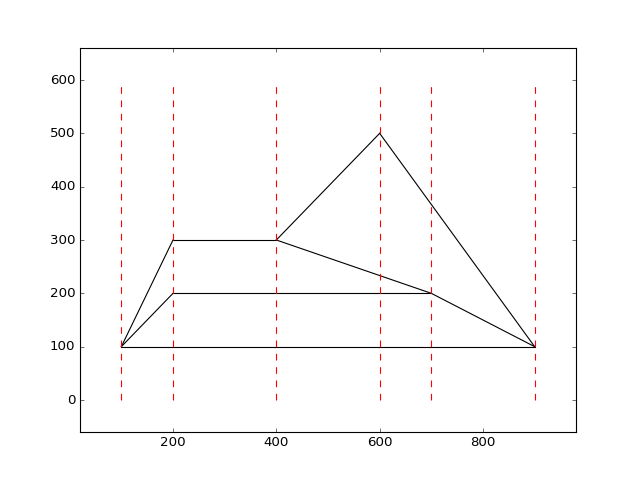

In [2]:
slabs = Slabs.read_slabs("sample02.txt")

def solve(slabs, point):
    pass

def onClick(event):
    fig.clear()
    point = Point(int(round(event.xdata)), int(round(event.ydata)))
    edge = solve(slabs, point)
    slabs.draw(edge, point)
    
fig = plt.figure(num=' ')
fig.canvas.mpl_connect('button_press_event', onClick)
slabs.draw()